In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import rasterio
from tqdm import tqdm
import tensorflow as tf

# Configuration
DATA_DIR = r"D:\My Disk\coding\v_2"
CLASSES = ['agri', 'barrenland', 'grassland', 'urban']
BATCH_SIZE = 16
IMG_SIZE = 256  # All images will be resized to this
EPOCHS = 50

C:\Users\len\.conda\envs\sarproject\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [13]:
def normalize_s1_s2(s1_img, s2_img, s1_db_range=(-50, 0), s2_max_value=10000):
    """
    Normalizes a single pair of S1 (SAR) and S2 (optical) images.
    
    Parameters:
        s1_img (np.ndarray): SAR image (typically float32, positive values)
        s2_img (np.ndarray): Optical image (typically uint16 or float)
        s1_db_range (tuple): Min/max dB values to normalize SAR (default: -50 to 0)
        s2_max_value (int): Maximum possible S2 value (default: 10000)
    
    Returns:
        Tuple of normalized (s1_img, s2_img) both scaled to [0, 1]
    """
    # SAR: linear → dB → normalized
    s1_img = 10 * np.log10(np.clip(s1_img, 1e-6, None))  # Avoid log(0)
    s1_min, s1_max = s1_db_range
    s1_img = np.clip((s1_img - s1_min) / (s1_max - s1_min), 0, 1)

    # Optical: clip and scale to [0, 1]
    s2_img = np.clip(s2_img, 0, s2_max_value) / s2_max_value

    return s1_img, s2_img


In [14]:
import h5py  # For efficient storage

def process_and_save_class(terrain, class_idx, data_dir, img_size=256):
    """
    Processes all S1/S2 images for one terrain class and saves to .h5 file.
    Returns the count of processed samples.
    """
    s1_dir = os.path.join(data_dir, terrain, 's1')
    s2_dir = os.path.join(data_dir, terrain, 's2')
    os.makedirs('temp_data', exist_ok=True)
    output_path = f'temp_data/{terrain}.h5'
    
    s1_files = [f for f in os.listdir(s1_dir) if f.endswith('.png')]
    X_s1 = []
    X_s2 = []
    
    for s1_file in tqdm(s1_files, desc=f"Processing {terrain}"):
        # Load S1
        with rasterio.open(os.path.join(s1_dir, s1_file)) as src:
            s1_img = np.moveaxis(src.read(), 0, -1)
        # Load S2 (assumes matching filename)
        s2_file = s1_file.replace('_s1', '_s2')
        with rasterio.open(os.path.join(s2_dir, s2_file)) as src:
            s2_img = np.moveaxis(src.read(), 0, -1)
        
        # Resize if needed
        if s1_img.shape[0] != img_size:
            import cv2
            s1_img = cv2.resize(s1_img, (img_size, img_size))
            s2_img = cv2.resize(s2_img, (img_size, img_size))
        
        # Normalize
        s1_img, s2_img = normalize_s1_s2(s1_img, s2_img)
        
        X_s1.append(s1_img)
        X_s2.append(s2_img)
    
    # Save to HDF5 (efficient binary format)
    with h5py.File(output_path, 'w') as hf:
        hf.create_dataset('X_s1', data=np.array(X_s1))
        hf.create_dataset('X_s2', data=np.array(X_s2))
        hf.create_dataset('y', data=np.full(len(X_s1), class_idx))
    
    return len(X_s1)

In [15]:
def load_all_classes(classes):
    """Loads preprocessed data from .h5 files and combines them."""
    X_s1, X_s2, y = [], [], []
    for class_idx, terrain in enumerate(classes):
        with h5py.File(f'temp_data/{terrain}.h5', 'r') as hf:
            X_s1.append(hf['X_s1'][:])
            X_s2.append(hf['X_s2'][:])
            y.append(hf['y'][:])
    
    # Combine all classes and convert labels to categorical
    X_s1_combined = np.concatenate(X_s1)
    X_s2_combined = np.concatenate(X_s2)
    y_combined = to_categorical(np.concatenate(y))
    
    return X_s1_combined, X_s2_combined, y_combined

In [16]:
import os
from pathlib import Path

# Check if temp files already exist
temp_dir = Path('temp_data')
if temp_dir.exists() and all((temp_dir / f"{terrain}.h5").exists() for terrain in CLASSES):
    print("HDF5 files already exist, skipping processing")
else:
    # Create directory if needed
    temp_dir.mkdir(exist_ok=True)
    
    # Process one class at a time (saves to disk automatically)
    for class_idx, terrain in enumerate(CLASSES):
        count = process_and_save_class(terrain, class_idx, DATA_DIR, IMG_SIZE)
        print(f"Processed {count} samples for {terrain}")

HDF5 files already exist, skipping processing


In [17]:
    for class_idx, terrain in enumerate(CLASSES):
        count = process_and_save_class(terrain, class_idx, DATA_DIR, IMG_SIZE)
        print(f"Processed {count} samples for {terrain}")

Processing agri: 100%|████████████████████████████| 4000/4000 [01:34<00:00, 42.25it/s]


Processed 4000 samples for agri


Processing barrenland: 100%|██████████████████████| 4000/4000 [01:35<00:00, 41.87it/s]


Processed 4000 samples for barrenland


Processing grassland: 100%|███████████████████████| 4000/4000 [01:33<00:00, 42.74it/s]


Processed 4000 samples for grassland


Processing urban: 100%|███████████████████████████| 4000/4000 [01:35<00:00, 41.80it/s]


Processed 4000 samples for urban


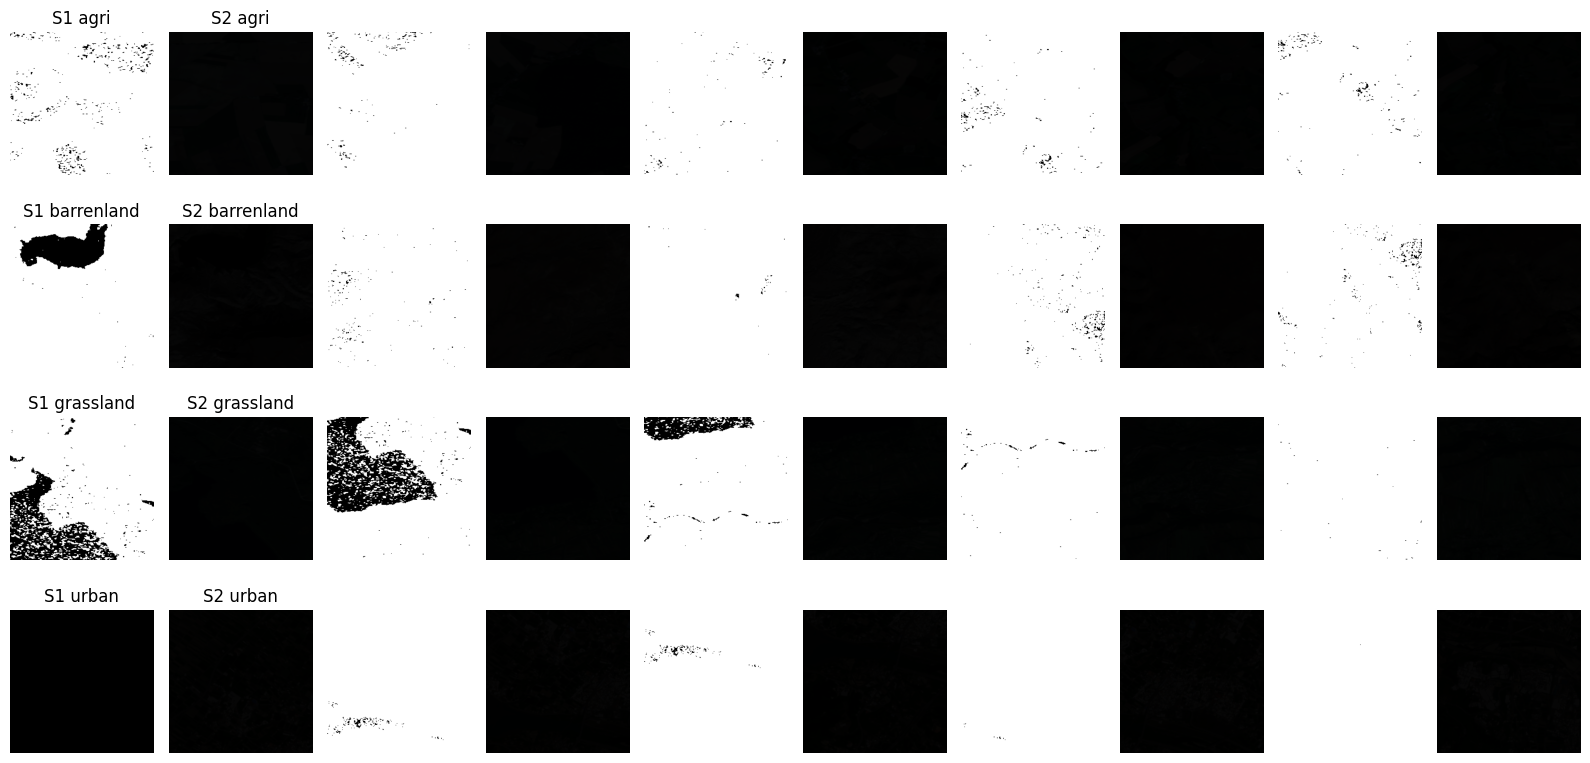

In [18]:
def visualize_samples_from_h5(classes, n_samples=5):
    """Visualizes samples directly from .h5 files without full loading"""
    plt.figure(figsize=(16, 8))
    
    for i, terrain in enumerate(classes):
        with h5py.File(f'temp_data/{terrain}.h5', 'r') as hf:
            # Load just a few samples per class
            s1_sample = hf['X_s1'][:n_samples]
            s2_sample = hf['X_s2'][:n_samples]
            y_sample = hf['y'][:n_samples]
            
            for j in range(n_samples):
                # SAR plot
                plt.subplot(len(classes), n_samples*2, i*(n_samples*2) + j*2 + 1)
                plt.imshow(s1_sample[j][:, :, 0], cmap='gray')
                plt.title(f"S1 {terrain}" if j==0 else "")
                plt.axis('off')
                
                # Optical plot
                plt.subplot(len(classes), n_samples*2, i*(n_samples*2) + j*2 + 2)
                if s2_sample[j].shape[-1] >= 3:
                    plt.imshow(s2_sample[j][:, :, :3])
                else:
                    plt.imshow(s2_sample[j][:, :, 0], cmap='viridis')
                plt.title(f"S2 {terrain}" if j==0 else "")
                plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage (visualizes 5 samples per class)
visualize_samples_from_h5(CLASSES, n_samples=5)